# ECE1513 Project - Credit Card Default Binary Prediction

Team Member:


* Yang (Viola) Song (1002467984)
* Xiangyu Liu (1006743179)
* Yian Zha (1002391592)

In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression

## Data Review and Exploratory Analysis


In [3]:
# Load Data from UCI Machine Learning Repository
raw_data = fetch_ucirepo(id=350)

# Data Extraction
feature_names= raw_data.data.feature_names
feature_data= raw_data.data.features
target_data= raw_data.data.targets

# Review the Dataset
df_feature = pd.DataFrame(data= feature_data, columns= feature_names )
df_target = pd.DataFrame(data= target_data, columns=['Y'])
df = df_feature.join(df_target)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Feature Info Description
var_info = raw_data.variables
var_info

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,None,None,no
1,X1,Feature,Integer,None,LIMIT_BAL,None,no
2,X2,Feature,Integer,Sex,SEX,None,no
3,X3,Feature,Integer,Education Level,EDUCATION,None,no
4,X4,Feature,Integer,Marital Status,MARRIAGE,None,no
5,X5,Feature,Integer,Age,AGE,None,no
6,X6,Feature,Integer,None,PAY_0,None,no
7,X7,Feature,Integer,None,PAY_2,None,no
8,X8,Feature,Integer,None,PAY_3,None,no
9,X9,Feature,Integer,None,PAY_4,None,no


In [6]:
# Target Data Distribution
print('Percentage of Credit Default is %.2f%% ' % (df.Y.sum()/len(df) * 100))

Percentage of Credit Default is 22.12% 


Since there is less than 25% of credit default in this dataset, we can conclude that the dataset is unbalanced.

In [7]:
df.columns = var_info['description'][1:].values
df.index.rename('ID', inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Data Cleaning and Preprocessing

In [8]:
# Info from UCI repo: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
df = df[~df['EDUCATION'].isin([0, 5, 6])] # no info on these 3 catogories, hence no interpretational value

In [9]:
# Info from UCI repo: X4: Marital status (1 = married; 2 = single; 3 = others)
df = df[~df['MARRIAGE'].isin([3])] # no interpretational value for this class

In [10]:
# Info from UCI repo: PAY_0 - Pay_6: History of past payment.
'''
  The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .;
  8 = payment delay for eight months; 9 = payment delay for nine months and above.
'''
# Rename PAY_0 as _1 is skipped in the original dataset
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)

# The columns PAY_n in the original dataset range from -2 to 8, however the measurement scale is from -1 to 9
# Rescale the value by shifting up 1
# since 0 is not documented so we will consider both -1 and 0 as -1
pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for p in pay_features:
    df.loc[df[p]<0, p] = -1
    df.loc[df[p]>=0, p] = df.loc[df[p]>=0, p] + 1
    df[p] = df[p].astype('int64')

In [11]:
# Split data into training and test
df=df.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(df[[i for i in df.columns if i!='default payment next month']], df['default payment next month'], test_size=0.3, random_state=42)

In [12]:
# Standardize the LIMIT_BAL, AGE, BILL_n and PAY_AMTn numerical columns
num_col = ["LIMIT_BAL", "AGE"] + [f"BILL_AMT{i}" for i in range(1, 7)] + [f"PAY_AMT{i}" for i in range(1, 7)]
scaler = StandardScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

## Exploratory Feature Analysis

### Feature - Target Correlation

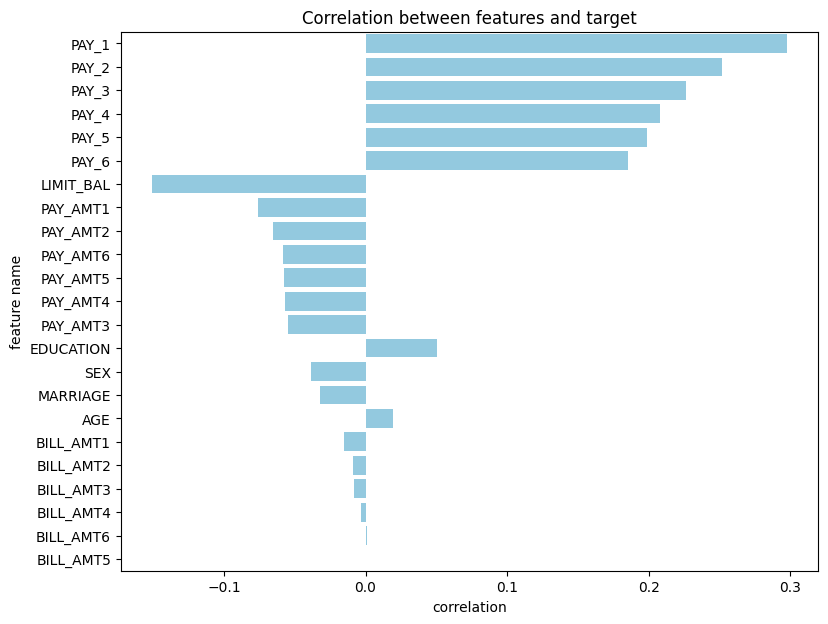

In [13]:
#combine the feature and the targe together to calculate the correlation
df_training = X_train.copy()
df_training["Target"] = y_train.copy()
df_corr = df_training.corr()

#visualize the features correlation
fea_name = df_corr.Target.abs().sort_values(ascending=False).index[1:30]
corr_score = df_corr.Target[fea_name]
fig, ax = plt.subplots(figsize=(9,7))
sns.barplot(x=corr_score.values, y=corr_score.index, color="skyblue", order=corr_score.abs().sort_values(ascending=False).index)
plt.title('Correlation between features and target')
plt.xlabel('correlation')
plt.ylabel('feature name')
plt.show()

### Features Correlation

In [14]:
#Display the top 10 feature pairs along with their correlation values
# Create a mask to exclude lower triangle (including diagonal)
mask = np.triu(np.ones(df_corr.shape), k=1).astype(bool)
upper_triangle = df_corr.where(mask)

# Find the top 10 pairs of features with the highest absolute correlations
top_correlations = upper_triangle.unstack().sort_values(ascending=False, key=lambda x: abs(x)).head(10)

# Display the top 10 correlated feature pairs and their correlation values
top_correlations_df = top_correlations.reset_index()
top_correlations_df['Feature Pairs'] = top_correlations_df['level_0'] + ' - ' + top_correlations_df['level_1']
top_correlations_df[['level_0','level_1', 0]]

,level_0,level_1,0
0,BILL_AMT2,BILL_AMT1,0.950176
1,BILL_AMT6,BILL_AMT5,0.949332
2,BILL_AMT5,BILL_AMT4,0.941539
3,BILL_AMT3,BILL_AMT2,0.935801
4,BILL_AMT4,BILL_AMT3,0.933335
5,BILL_AMT6,BILL_AMT4,0.903254
6,BILL_AMT3,BILL_AMT1,0.898350
7,BILL_AMT4,BILL_AMT2,0.895018
8,BILL_AMT5,BILL_AMT3,0.894909
9,BILL_AMT5,BILL_AMT2,0.864738


Based on the analysis above, we conclude that all **BILL_AMTn** features are highly correlated with each other but exhibit low correlation with the target variable. Therefore, we will retain **BILL_AMT1**, as it has the highest correlation with the target variable, and drop **BILL_AMT2 to BILL_AMT6** to reduce redundancy.

In [13]:
X_train.drop(columns=['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], inplace=True)
X_test.drop(columns=['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], inplace=True)

## Logistic Regression Model

### Create the Logistic Regression Model with balanced weight

In [14]:
# Train the model
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

### Initial Model Evaluation as Baseline

In [15]:
# Define multiple scoring metrics
scoring = {'accuracy': 'accuracy', 'f1': 'f1_macro', 'roc_auc': 'roc_auc_ovr'}

# Calculate baseline model metrics
baseline_cv_scores = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Display the 5-fold Cross Validatin Result
lr_baseline_results_df = pd.DataFrame(baseline_cv_scores)
lr_baseline_results_df.loc['mean'] = lr_baseline_results_df.mean()

print("Cross-Validation Results Table:")
lr_baseline_results_df

Cross-Validation Results Table:


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.190351,0.118591,0.638909,0.625700,0.593847,0.582745,0.721712,0.717212
1,0.134564,0.021104,0.628683,0.637509,0.582800,0.591430,0.707498,0.718063
2,0.265441,0.085499,0.635013,0.634831,0.587797,0.589465,0.714266,0.717736
3,0.201700,0.042737,0.629413,0.636900,0.583545,0.590631,0.712990,0.717447
4,0.173905,0.040395,0.630874,0.631605,0.587410,0.585820,0.717648,0.716560
mean,0.193193,0.061665,0.632579,0.633309,0.587080,0.588018,0.714823,0.717404


### Hyperparameters Tuning

In [ ]:
param_grid = [
    # For 'l1' penalty
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]},

    # For 'l2' penalty
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear', 'saga'], 'max_iter': [100, 200, 500]},

    # For 'elasticnet' penalty
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.9], 'max_iter': [100, 200, 500]},
]


In [ ]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring=scoring, verbose=2, n_jobs=-1, refit='roc_auc')
grid_search.fit(X_train, y_train)
best_lr_model = grid_search.best_estimator_

# Display best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC_AUC score: {grid_search.best_score_ :.6f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best ROC_AUC score: 0.715516


In [ ]:
# Set pandas display options to show more content
pd.set_option('display.max_colwidth', None)  # This removes the truncation of long text in columns
pd.set_option('display.width', None)  # Adjusts the total width of the display
pd.set_option('display.max_columns', None)  # Ensures all columns are displayed

In [ ]:
# Convert cv_results to DataFrame
lr_model_results_df = pd.DataFrame(grid_search.cv_results_)
ranked_lr_model_results_df = lr_model_results_df.sort_values(by='mean_test_roc_auc', ascending=False)
ranked_lr_model_results_df[['params', 'mean_test_accuracy', 'mean_test_f1','mean_test_roc_auc']][:3]

,params,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
1,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}",0.621135,0.579192,0.715516
3,"{'C': 0.01, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}",0.621135,0.579192,0.715516
5,"{'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}",0.621135,0.579192,0.715516


### ROC AUC Plot for Linear Reg Models

In [ ]:
# Best LR model from GridSearchCV: Predict probabilities using cross-validation for AUC Plot
best_lr_model_probs = cross_val_predict(
    best_lr_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]
best_lr_model_auc = roc_auc_score(y_train, best_lr_model_probs)

In [ ]:
# Baseline model: Predict probabilities using cross-validation for AUC Plot
lr_baseline_probs = cross_val_predict(
    lr_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]  # Probabilities for the positive class
lr_baseline_auc = roc_auc_score(y_train, lr_baseline_probs)

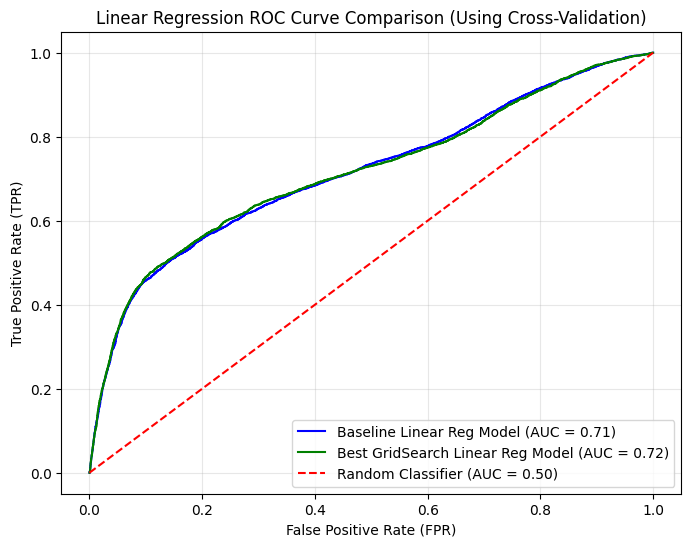

In [ ]:
# Compute ROC curve for each model
lr_baseline_fpr, lr_baseline_tpr, _ = roc_curve(y_train, lr_baseline_probs)
best_lr_fpr, best_lr_tpr, _ = roc_curve(y_train, best_lr_model_probs)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(lr_baseline_fpr, lr_baseline_tpr, label=f'Baseline Linear Reg Model (AUC = {lr_baseline_auc:.2f})', color='blue')
plt.plot(best_lr_fpr, best_lr_tpr, label=f'Best GridSearch Linear Reg Model (AUC = {best_lr_model_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)')
plt.title('Linear Regression ROC Curve Comparison (Using Cross-Validation)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Random Forest Model




### Create the Random Forest Model

In [16]:
#Create the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

### Initial Model Evaluation as baseline

In [ ]:
# Calculate baseline model metrics
rf_baseline_cv_scores = cross_validate(rf_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Display the 5-fold Cross Validatin Result
rf_baseline_results_df = pd.DataFrame(rf_baseline_cv_scores)
rf_baseline_results_df.loc['mean'] = rf_baseline_results_df.mean()

print("Cross-Validation Results Table:")
rf_baseline_results_df

Cross-Validation Results Table:


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,5.525590,0.249885,0.817628,0.999635,0.682733,0.999473,0.771611,0.999963
1,4.261920,0.203036,0.816411,0.999513,0.673156,0.999297,0.771475,0.999962
2,4.288197,0.193666,0.816411,0.999696,0.676852,0.999561,0.765658,0.999976
3,5.486990,0.201657,0.812272,0.999817,0.665595,0.999736,0.773911,0.999990
4,4.630105,0.290190,0.820307,0.999757,0.682275,0.999648,0.771649,0.999959
mean,4.838560,0.227687,0.816606,0.999683,0.676122,0.999543,0.770861,0.999970


### Hyperparameters Tuning

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],     # Number of trees
    'max_depth': [None, 10, 20],             # Depth of trees
    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples per leaf node
}

In [19]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=scoring, verbose=2, n_jobs=-1, refit='roc_auc')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Display best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC_AUC score: {grid_search.best_score_ :.6f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Best ROC_AUC score: 0.782441


In [ ]:
# Convert cv_results to DataFrame
rf_model_results_df = pd.DataFrame(grid_search.cv_results_)
ranked_rf_model_results_df = rf_model_results_df.sort_values(by='mean_test_roc_auc', ascending=False)
ranked_rf_model_results_df[['params', 'mean_test_accuracy', 'mean_test_f1','mean_test_roc_auc']][:3]

,params,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
63,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}",0.789335,0.704339,0.782441
67,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 500}",0.789335,0.704339,0.782441
71,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}",0.788605,0.703868,0.782331


### ROC AUC Plot for Random Forest Models




In [ ]:
# Baseline model: Predict probabilities using cross-validation for AUC Plot
rf_baseline_probs = cross_val_predict(
    rf_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]  # Probabilities for the positive class
rf_baseline_auc = roc_auc_score(y_train, lr_baseline_probs)

In [ ]:
# Best LR model from GridSearchCV: Predict probabilities using cross-validation for AUC Plot
best_rf_model_probs = cross_val_predict(
    best_rf_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]
best_rf_model_auc = roc_auc_score(y_train, best_rf_model_probs)

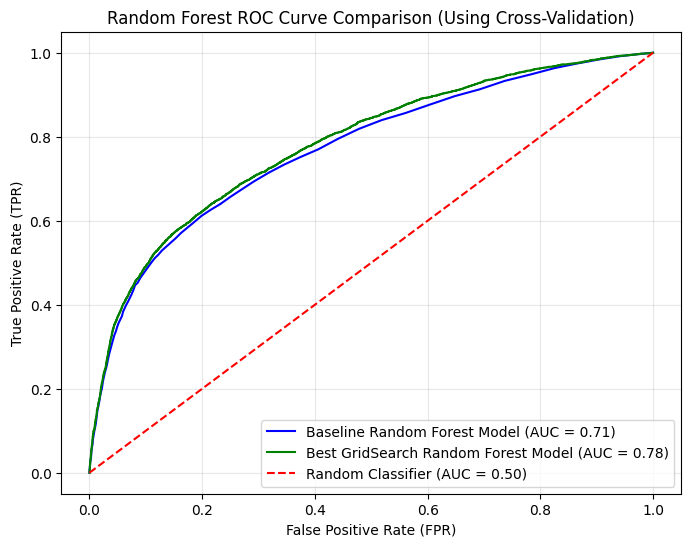

In [ ]:
# Compute ROC curve for each model
rf_baseline_fpr, rf_baseline_tpr, _ = roc_curve(y_train, rf_baseline_probs)
best_rf_fpr, best_rf_tpr, _ = roc_curve(y_train, best_rf_model_probs)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(rf_baseline_fpr, rf_baseline_tpr, label=f'Baseline Random Forest Model (AUC = {rf_baseline_auc:.2f})', color='blue')
plt.plot(best_rf_fpr, best_rf_tpr, label=f'Best GridSearch Random Forest Model (AUC = {best_rf_model_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)')
plt.title('Random Forest ROC Curve Comparison (Using Cross-Validation)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## SVM Model

### Linear SVM  (Soft Margin SVM)




#### Create the Linear SVM Model

In [ ]:
# Create the Linear SVM model
linear_svm = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)

#### Initial Model Evaluation as baseline

In [ ]:
# Calculate baseline model metrics
linear_svm_baseline_cv_scores = cross_validate(linear_svm, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Display the 5-fold Cross Validatin Result
linear_svm_baseline_results_df = pd.DataFrame(linear_svm_baseline_cv_scores)
linear_svm_baseline_results_df.loc['mean'] = linear_svm_baseline_results_df.mean()

print("Cross-Validation Results Table:")
linear_svm_baseline_results_df

Cross-Validation Results Table:


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,28.861258,0.825254,0.655953,0.651084,0.604128,0.600493,0.714749,0.715600
1,29.049781,0.763001,0.646944,0.654371,0.596591,0.603109,0.709588,0.716103
2,27.418514,0.764023,0.654249,0.649257,0.602729,0.599273,0.716964,0.716241
3,28.065756,0.766285,0.652057,0.655162,0.600452,0.603678,0.713599,0.716000
4,28.093819,0.759758,0.651327,0.656075,0.600969,0.604228,0.715335,0.715268
mean,28.297826,0.775664,0.652106,0.653190,0.600974,0.602156,0.714047,0.715842


#### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for tuning the C parameter
param_grid = {'C': [0.01, 0.1, 1, 100]}  # Experiment with different values of C

# Perform Grid Search
grid_search = GridSearchCV(estimator=linear_svm, param_grid=param_grid, cv=5, scoring=scoring, verbose=2, n_jobs=-1, refit='roc_auc')
grid_search.fit(X_train, y_train)
best_linear_svm_model = grid_search.best_estimator_

# Display best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC_AUC score: {grid_search.best_score_ :.6f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time=  46.5s
[CV] END .............................................C=0.01; total time=  47.0s
[CV] END .............................................C=0.01; total time=  47.1s
[CV] END .............................................C=0.01; total time=  47.2s
[CV] END .............................................C=0.01; total time=  47.9s
[CV] END ..............................................C=0.1; total time=  49.9s
[CV] END ..............................................C=0.1; total time=  50.0s
[CV] END ..............................................C=0.1; total time=  50.4s
[CV] END ..............................................C=0.1; total time=  50.6s
[CV] END ..............................................C=0.1; total time=  51.4s
[CV] END ................................................C=1; total time= 1.2min
[CV] END ........................................

In [ ]:
# Convert cv_results to DataFrame
linear_svm_model_results_df = pd.DataFrame(grid_search.cv_results_)
ranked_linear_svm_model_results_df = linear_svm_model_results_df.sort_values(by='mean_test_roc_auc', ascending=False)
ranked_linear_svm_model_results_df[['params', 'mean_test_accuracy', 'mean_test_f1','mean_test_roc_auc']][:3]

,params,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
0,{'C': 0.01},0.649282,0.598917,0.714386
3,{'C': 100},0.651863,0.600743,0.714105
1,{'C': 0.1},0.651911,0.600878,0.714066


#### ROC AUC Calculation

In [ ]:
# Baseline model: Predict probabilities using cross-validation for AUC Plot
linear_svm_baseline_probs = cross_val_predict(
    linear_svm, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]  # Probabilities for the positive class
linear_svm_baseline_auc = roc_auc_score(y_train, linear_svm_baseline_probs)

In [ ]:
# Best LR model from GridSearchCV: Predict probabilities using cross-validation for AUC Plot
best_linear_svm_model_probs = cross_val_predict(
    best_linear_svm_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]
best_linear_svm_model_auc = roc_auc_score(y_train, best_linear_svm_model_probs)

### Non-linear Kernel SVM

#### RBF kernel




##### Create the SVM model with RBF kernel

In [ ]:
# Create the SVM model with RBF kernel
rbf_svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

##### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for RBF kernel
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [0.01, 0.1, 1]  # Kernel coefficient for RBF
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=rbf_svm, param_grid=param_grid, cv=5, scoring=scoring, verbose=2, n_jobs=-1, refit='roc_auc')
grid_search.fit(X_train, y_train)
best_rbf_svm_model = grid_search.best_estimator_

# Display best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC_AUC score: {grid_search.best_score_ :.6f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.2min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.2min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.2min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.3min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.3min
[CV] END .....................................C=0.1, gamma=1; total time= 1.4min
[CV] END ....................................C=1,

In [ ]:
# Convert cv_results to DataFrame
rbf_svm_model_results_df = pd.DataFrame(grid_search.cv_results_)
ranked_rbf_svm_model_results_df = rbf_svm_model_results_df.sort_values(by='mean_test_roc_auc', ascending=False)
ranked_rbf_svm_model_results_df[['params', 'mean_test_accuracy', 'mean_test_f1','mean_test_roc_auc']][:3]

,params,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
3,"{'C': 1, 'gamma': 0.01}",0.776674,0.693393,0.766761
6,"{'C': 10, 'gamma': 0.01}",0.773557,0.692766,0.765286
1,"{'C': 0.1, 'gamma': 0.1}",0.764889,0.687042,0.756776


##### ROC AUC Calculation

In [ ]:
# Best LR model from GridSearchCV: Predict probabilities using cross-validation for AUC Plot
best_rbf_svm_model_probs = cross_val_predict(
    best_rbf_svm_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]
best_rbf_svm_model_auc = roc_auc_score(y_train, best_rbf_svm_model_probs)

#### Polynomial Kernel


##### Create the SVM model with Polynomial kernel

In [ ]:
# Create the SVM model with polynomial kernel
poly_svm = SVC(kernel='poly', class_weight='balanced', probability=True, random_state=42)

##### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for polynomial kernel
param_grid = {
    'C': [0.1, 1, 10],         # Regularization parameter
    'degree': [2, 3, 4],       # Degree of the polynomial kernel
    'coef0': [1],           # Independent term in the kernel function
    'gamma': ['scale']  # Kernel coefficient for 'poly'
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=poly_svm, param_grid=param_grid, cv=5, scoring=scoring, verbose=2, n_jobs=-1, refit='roc_auc')
grid_search.fit(X_train, y_train)
best_poly_svm_model = grid_search.best_estimator_

# Display best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC_AUC score: {grid_search.best_score_ :.6f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..............C=0.1, coef0=1, degree=2, gamma=scale; total time=  45.3s
[CV] END ..............C=0.1, coef0=1, degree=2, gamma=scale; total time=  45.3s
[CV] END ..............C=0.1, coef0=1, degree=2, gamma=scale; total time=  45.4s
[CV] END ..............C=0.1, coef0=1, degree=2, gamma=scale; total time=  45.6s
[CV] END ..............C=0.1, coef0=1, degree=2, gamma=scale; total time=  45.7s
[CV] END ..............C=0.1, coef0=1, degree=3, gamma=scale; total time=  46.3s
[CV] END ..............C=0.1, coef0=1, degree=3, gamma=scale; total time=  46.4s
[CV] END ..............C=0.1, coef0=1, degree=3, gamma=scale; total time=  46.4s
[CV] END ..............C=0.1, coef0=1, degree=3, gamma=scale; total time=  46.7s
[CV] END ..............C=0.1, coef0=1, degree=3, gamma=scale; total time=  46.9s
[CV] END ..............C=0.1, coef0=1, degree=4, gamma=scale; total time=  52.3s
[CV] END ..............C=0.1, coef0=1, degree=4, 

In [ ]:
# Convert cv_results to DataFrame
poly_svm_model_results_df = pd.DataFrame(grid_search.cv_results_)
ranked_poly_svm_model_results_df = poly_svm_model_results_df.sort_values(by='mean_test_roc_auc', ascending=False)
ranked_poly_svm_model_results_df[['params', 'mean_test_accuracy', 'mean_test_f1','mean_test_roc_auc']][:3]

,params,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
1,"{'C': 0.1, 'coef0': 1, 'degree': 3, 'gamma': '...",0.777891,0.694610,0.765765
0,"{'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': '...",0.780521,0.690918,0.762930
2,"{'C': 0.1, 'coef0': 1, 'degree': 4, 'gamma': '...",0.774531,0.692589,0.761894


##### ROC AUC Plot for all SVM Models

In [ ]:
# Best LR model from GridSearchCV: Predict probabilities using cross-validation for AUC Plot
best_poly_svm_model_probs = cross_val_predict(
    best_poly_svm_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1
)[:, 1]
best_poly_svm_model_auc = roc_auc_score(y_train, best_poly_svm_model_probs)

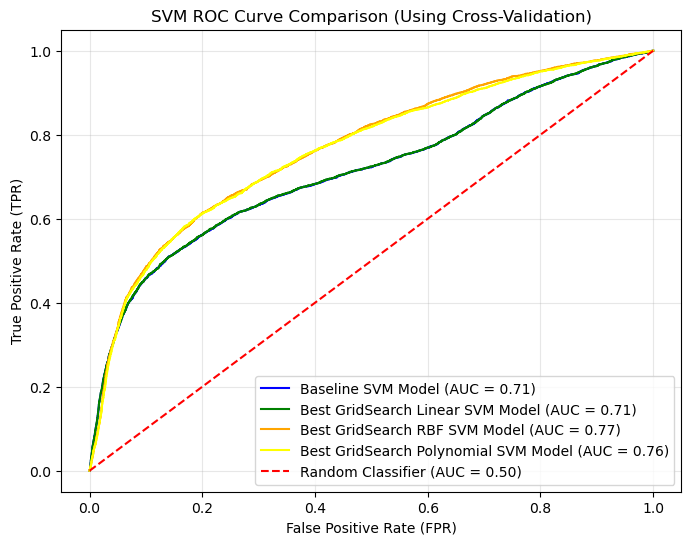

In [ ]:
# Compute ROC curve for each model
linear_svm_baseline_fpr, linear_svm_baseline_tpr, _ = roc_curve(y_train, linear_svm_baseline_probs)
best_linear_svm_fpr, best_linear_svm_tpr, _ = roc_curve(y_train, best_linear_svm_model_probs)
best_rbf_svm_fpr, best_rbf_svm_tpr, _ = roc_curve(y_train, best_rbf_svm_model_probs)
best_poly_svm_fpr, best_poly_svm_tpr, _ = roc_curve(y_train, best_poly_svm_model_probs)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(linear_svm_baseline_fpr, linear_svm_baseline_tpr, label=f'Baseline SVM Model (AUC = {linear_svm_baseline_auc:.2f})', color='blue')
plt.plot(best_linear_svm_fpr, best_linear_svm_tpr, label=f'Best GridSearch Linear SVM Model (AUC = {best_linear_svm_model_auc:.2f})', color='green')
plt.plot(best_rbf_svm_fpr, best_rbf_svm_tpr, label=f'Best GridSearch RBF SVM Model (AUC = {best_rbf_svm_model_auc:.2f})', color='orange')
plt.plot(best_poly_svm_fpr, best_poly_svm_tpr, label=f'Best GridSearch Polynomial SVM Model (AUC = {best_poly_svm_model_auc:.2f})', color='yellow')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)')
plt.title('SVM ROC Curve Comparison (Using Cross-Validation)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Model Comparison and Evaluation

| Model Candidates | Parameter |  Average AUC ROC Score on 5-fold Validation |
| --- | --- | --- |
| Logistic Regression | 'class_weight': balanced, 'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'| 0.715516 |
| Random Forest | 'class_weight': balanced, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500  | 0.782441|
| Linear SVM | 'class_weight': balanced, 'kernal': linear, 'C': 0.01 | 0.714386 |
| Non-linear RBF SVM | 'class_weight': balanced, 'kernal': rbf, 'C': 1, 'gamma': 0.01 | 0.766761 |
| Non-linear Polynomial SVM | 'class_weight': balanced, 'kernel': poly, 'C': 0.1, 'coef0': 1, 'degree': 3, 'gamma': scale  | 0.765765 |

In an imbalanced dataset, metrics like accuracy can be misleading because they favor the majority class. AUC-ROC is a more fair metric as it focuses on the model's ability to distinguish between the positive (default risk) and negative (no default) classes, regardless of their proportions.

The AUC-ROC is calculated based on 2 importance rate; the True Positive Rate and False Positive Rate. This is crucial in credit default prediction, as both false positives (flagging a safe client as risky) and false negatives (missing a default risk) present a high cost consequence.

From the table above, the Random Forest model outperfoms the other ML models with a AUC ROC score of 0.78 through a 5-fold cross validation evaluation. We will be using this prediction model on our test dataset for the final result.

## Final Model Performance Review

AUC-ROC Score: 0.7747


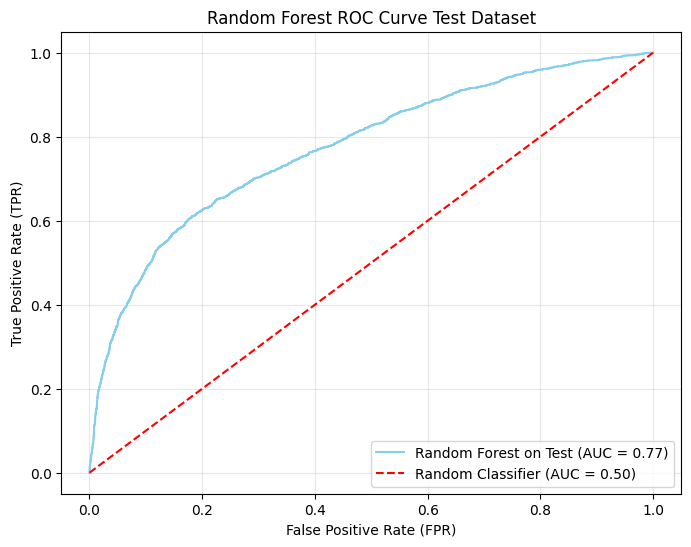

In [22]:
# Make predictions on the test data
y_pred_probs = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred = best_rf_model.predict(X_test)  # Predicted class labels

# Evaluate the model
auc_score_test = roc_auc_score(y_test, y_pred_probs)

# Print evaluation metrics
print(f"AUC-ROC Score: {auc_score_test:.4f}")

# Compute ROC curve for each model
test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_probs)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, label=f'Random Forest on Test (AUC = {auc_score_test:.2f})',color='skyblue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)')
plt.title('Random Forest ROC Curve Test Dataset')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()